# Part 1: MLP

## Load and Preprocess the Dataset

In [439]:
# import packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [390]:
# Reading in the training/test data

file_path = '../data/project_adult.csv'

try:
    df = pd.read_csv(file_path, header=None, encoding='utf-8')
    print(f"Successfully loaded '{file_path}'. First 5 rows:")
    print(df.head())
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except pd.errors.EmptyDataError:
    print(f"Error: The file '{file_path}' is empty or contains no data.")
except pd.errors.ParserError as e:
    print(f"Error: A parsing error occurred while reading '{file_path}': {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully loaded '../data/project_adult.csv'. First 5 rows:
        0    1                 2       3          4              5   \
0      NaN  age         workclass  fnlwgt  education  education-num   
1   5514.0   33         Local-gov  198183  Bachelors             13   
2  19777.0   36           Private   86459  Assoc-voc             11   
3  10781.0   58  Self-emp-not-inc  203039        9th              5   
4  32240.0   21           Private  180190  Assoc-voc             11   

                   6                7              8      9       10  \
0      marital-status       occupation   relationship   race     sex   
1       Never-married   Prof-specialty  Not-in-family  White  Female   
2  Married-civ-spouse  Exec-managerial        Husband  White    Male   
3           Separated     Craft-repair  Not-in-family  White    Male   
4  Married-civ-spouse  Farming-fishing        Husband  White    Male   

             11            12              13              14      15  
0  ca

In [391]:
# Reading in the validation data

file_path = '../data/project_validation_inputs.csv'

try:
    df_test = pd.read_csv(file_path, header=None, encoding='utf-8')
    print(f"Successfully loaded '{file_path}'. First 5 rows:")
    print(df_test.head())
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except pd.errors.EmptyDataError:
    print(f"Error: The file '{file_path}' is empty or contains no data.")
except pd.errors.ParserError as e:
    print(f"Error: A parsing error occurred while reading '{file_path}': {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully loaded '../data/project_validation_inputs.csv'. First 5 rows:
        0    1          2       3             4              5   \
0      NaN  age  workclass  fnlwgt     education  education-num   
1  14160.0   27    Private  160178  Some-college             10   
2  27048.0   45  State-gov   50567       HS-grad              9   
3  28868.0   29    Private  185908     Bachelors             13   
4   5667.0   30    Private  190040     Bachelors             13   

                   6                  7              8      9       10  \
0      marital-status         occupation   relationship   race     sex   
1            Divorced       Adm-clerical  Not-in-family  White  Female   
2  Married-civ-spouse    Exec-managerial           Wife  White  Female   
3  Married-civ-spouse    Exec-managerial        Husband  Black    Male   
4       Never-married  Machine-op-inspct  Not-in-family  White  Female   

             11            12              13              14  
0  capital-ga

In [ ]:
# process and standardize the test/train data function
def preprocess_data(df):

    # Drop the first column (seems like just a random index) and first row (column names)
    df = df.iloc[1:, 1:]
    
    # correct column names
    new_column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'class']
    df.columns = new_column_names

    # Handle missing values
    df.replace('?', 'Missing', inplace=True)  # Letting missing values be their own class as they're only in categorical columns

    # Binarize the target variable (will change at the end to match requested format for submission)
    df['class'] = df['class'].apply(lambda x: 1 if x == '>50K' else 0)

    # Keep track of rows indexes to connect X and y
    df = df.reset_index(names=['original_index'])

    # Encode categorical features
    df = pd.get_dummies(df, columns=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country', 'sex'], dtype = int)

    # Ensure all data types are numeric after encoding
    df = df.apply(pd.to_numeric, errors='coerce')

    # Separate features and target
    X = df.drop(columns=['class'], axis=1)
    y = df[['original_index','class']]

    # Standardize numerical features
    numeric_cols = ['age','fnlwgt','education-num','capital-gain', 'capital-loss', 'hours-per-week']
    scaler = StandardScaler()
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

    # Display preprocessed data
    merged_df = pd.concat([X, y['class']], axis=1)
    display(merged_df.head())

    # Return encoding to be using for validation data to maintain consistency
    return X, y

In [393]:
# Preprocess training/test data
X, y = preprocess_data(df)

,original_index,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Missing,...,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,sex_Female,sex_Male,class
0,1,-0.408756,0.080051,1.133702,-0.145715,-0.217998,0.779460,0,1,0,...,0,0,0,0,1,0,0,1,0,1
1,2,-0.188857,-0.981653,0.357049,-0.145715,4.457168,0.779460,0,0,0,...,0,0,0,0,1,0,0,0,1,1
2,3,1.423734,0.126197,-1.972910,-0.145715,-0.217998,-0.031510,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,4,-1.288351,-0.090935,0.357049,-0.145715,-0.217998,0.455072,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,5,-0.848554,0.856334,-0.031277,-0.145715,-0.217998,-0.031510,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [394]:
# Process and standardize validation data function
# Decided to create another function and remove any lines related to target column so that it worked for the validation dataset

def preprocess_validation_data(df):

    # Drop the first column (seems like just a random index) and first row (column names)
    df = df.iloc[1:, 1:]
    
    # correct column names
    new_column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
    df.columns = new_column_names

    # Handle missing values
    df.replace('?', 'Missing', inplace=True) # Letting missing values be their own class as they're only in categorical columns

    # keep track of rows indexes to connect X and y
    df = df.reset_index(names=['original_index'])

    # Encode categorical features
    df = pd.get_dummies(df, columns=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country', 'sex'], dtype = int)

    # Ensure all data is numeric after encoding
    df = df.apply(pd.to_numeric, errors='coerce')

    # Assign features to X
    X = df

    # Standardize numerical features
    numeric_cols = ['age','fnlwgt','education-num','capital-gain', 'capital-loss', 'hours-per-week']
    scaler = StandardScaler()
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

    # display preprocessed data
    display(X.head())

    return X

In [395]:
# preprocess validation data
X_df_test = preprocess_validation_data(df_test)

,original_index,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Missing,...,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,sex_Female,sex_Male
0,1,-0.851191,-0.277853,-0.031693,-0.147225,-0.211274,-0.212164,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,2,0.469374,-1.304090,-0.421896,-0.147225,-0.211274,-0.051009,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,3,-0.704461,-0.036955,1.138915,-0.147225,-0.211274,1.157652,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,4,-0.631097,0.001731,1.138915,-0.147225,-0.211274,-0.051009,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,5,-0.704461,-0.004766,-0.031693,0.128973,-0.211274,0.754765,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [396]:
# splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1./3, random_state=1)

In [397]:
# assigning feature columns to variable for easy recall and avoid dropping 'original_index'
# also validation dataset lacked 3 columns after encoded so excluding those as well to avoid shape mismatch issues

feature_cols = [col for col in X_train.columns if col not in ['original_index', 'workclass_Never-worked', 'native-country_Holand-Netherlands', 'native-country_Outlying-US(Guam-USVI-etc)']]
print(feature_cols)

['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_Federal-gov', 'workclass_Local-gov', 'workclass_Missing', 'workclass_Private', 'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc', 'workclass_State-gov', 'workclass_Without-pay', 'education_10th', 'education_11th', 'education_12th', 'education_1st-4th', 'education_5th-6th', 'education_7th-8th', 'education_9th', 'education_Assoc-acdm', 'education_Assoc-voc', 'education_Bachelors', 'education_Doctorate', 'education_HS-grad', 'education_Masters', 'education_Preschool', 'education_Prof-school', 'education_Some-college', 'marital-status_Divorced', 'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse', 'marital-status_Married-spouse-absent', 'marital-status_Never-married', 'marital-status_Separated', 'marital-status_Widowed', 'occupation_Adm-clerical', 'occupation_Armed-Forces', 'occupation_Craft-repair', 'occupation_Exec-managerial', 'occupation_Farming-fishing', 'occupation

## Train and Test MLP Model Candidates

In [ ]:
# converting training data to PyTorch tensors 
X_train = torch.from_numpy(X_train.loc[:,feature_cols].values).float()
y_train = torch.from_numpy(y_train.loc[:,'class'].values)

# creating a TensorDataset for training data
train_ds = TensorDataset(X_train, y_train)

### Running model as is from in class code:
- Wanted to use the in class code as a baseline model and starting point

In [ ]:
# Model from the in-class example that was applied to the Iris dataset

# creating a DataLoader with larger batch size for speed
torch.manual_seed(1)
batch_size = 64  # increase from 2 to reduce number of iterations per epoch
train_dl = DataLoader(train_ds, batch_size, shuffle=True) 

# defining the model architecture
class Model(nn.Module):
    
    # constructor with 1 hidden layer
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
    
    # forward pass using activation function Sigmoid and Softmax
    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Softmax(dim=1)(x)

        return x

input_size = X_train.shape[1]
hidden_size = 16
output_size = 2
model_1 = Model(input_size, hidden_size, output_size)

# defining the loss function
loss_fn = nn.CrossEntropyLoss()

# defining the optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)

# training the model and recording loss and accuracy
num_epochs = 100
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

# training loop
for epoch in range(num_epochs):

    # iterating through batches
    for x_batch, y_batch in train_dl:
        # 1. generate predictions
        pred = model_1(x_batch)
        # 2. calculate the loss
        loss = loss_fn(pred, y_batch.long())
        # 3. compute gradients
        loss.backward()
        # 4. update model parameters using gradients
        optimizer.step()
        # 5. reset the gradients to zero
        optimizer.zero_grad()

        # recording loss and accuracy
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()

    # normalizing loss and accuracy
    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

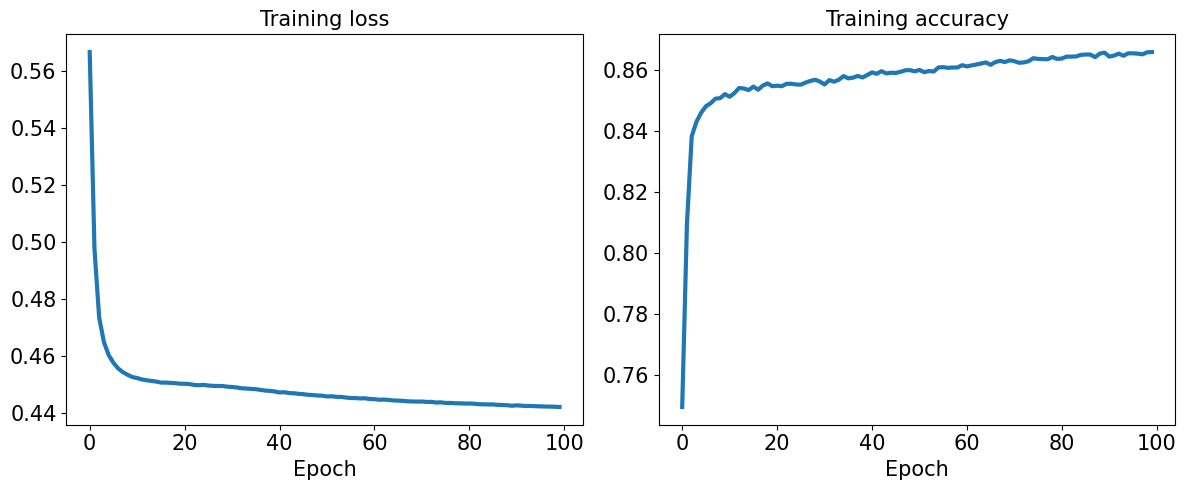

In [400]:
# plotting the loss and accuracy
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

# second subplot
ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()

In [401]:
# converting to PyTorch tensor
X_test = torch.from_numpy(X_test.loc[:,feature_cols].values).float()

# converting y_test to a tensor
y_test = torch.from_numpy(y_test.loc[:,'class'].values)

In [402]:
# making predictions on the test set
pred_test_1 = model_1(X_test)

# calculating the accuracy on the test set
correct = (torch.argmax(pred_test_1, dim=1) == y_test).float()
accuracy = correct.mean()
print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.8542


### Creating another version and changing architecture to be better suited for binary classification:

In [ ]:
# new model, testing other activation functions and number of layers
# tried out using sigmoid and BCELoss combination as recommended by lecture slides for binary classification 
    # but also found from research that BCEWithLogitsLoss is more stable and combines the two
    # tested both and second option performed better

# creating a DataLoader with larger batch size for speed
torch.manual_seed(1)
batch_size = 64 
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

# defining the model architecture
class Model_2(nn.Module):

    # constructor with 1 hidden layer
    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(p=dropout_rate)           # added dropout for overfitting
        self.layer2 = nn.Linear(hidden_size, output_size)
    
    # forward pass using activation function ReLu
    # tested some other activation functions but this seems to be best
    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.dropout(x) 
        x = self.layer2(x)

        return x


input_size = X_train.shape[1]
hidden_size = 64
output_size = 1
dropout_rate = 0.3  # went with a dropout rate that was conservative but still effective
model_2 = Model_2(input_size, hidden_size, output_size, dropout_rate)

# defining the loss function
loss_fn = nn.BCEWithLogitsLoss()

# defining the optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(model_2.parameters(), lr=learning_rate)

# training the model and recording loss and accuracy
num_epochs = 75
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

# training loop
for epoch in range(num_epochs):

    # iterating through batches
    for x_batch, y_batch in train_dl:
        # 1. generate predictions
        pred = model_2(x_batch)
        # 2. calculate the loss
        loss = loss_fn(pred.squeeze(1), y_batch.float())
        # 3. compute gradients
        loss.backward()
        # 4. update model parameters using gradients
        optimizer.step()
        # 5. reset the gradients to zero
        optimizer.zero_grad()

        # recording loss and accuracy
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        # had to edit is_correct calculation to convert outputs to probabilities and apply threshold
        is_correct = ((torch.sigmoid(pred.squeeze(1)) >= 0.5).float() == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()

    # normalizing loss and accuracy
    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

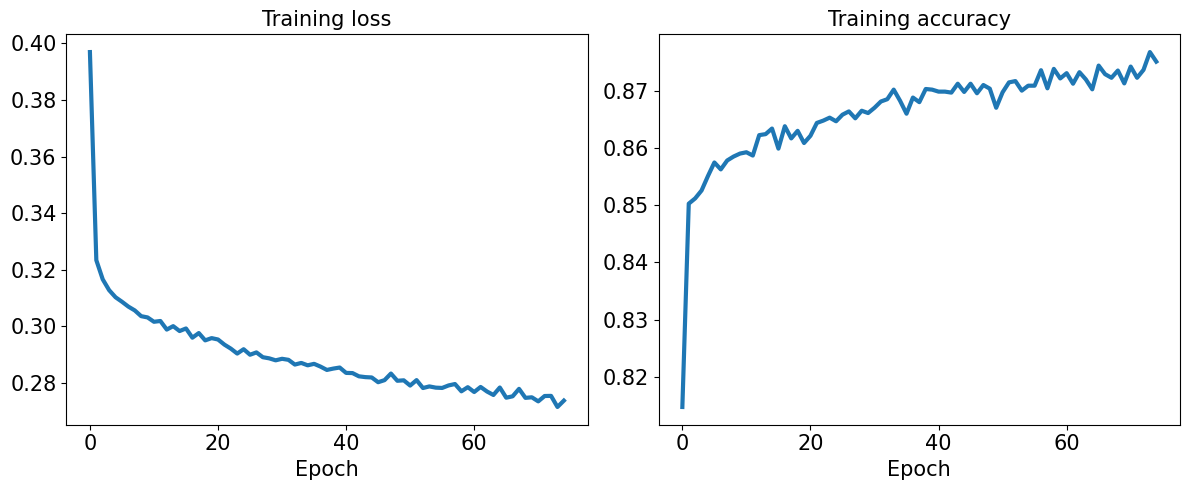

In [430]:
# plotting the loss and accuracy
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

# second subplot
ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()



In [ ]:
# make sure model is in evaluation mode
model_2.eval()

# predict on the test set
pred_test = model_2(X_test)

# apply torch.sigmoid to conver outputs to probabilities
pred_probs = torch.sigmoid(pred_test)

# define threshold for classification
pred_labels = (pred_probs.squeeze(1) >= 0.5).float()

# calculate accuracy
accuracy = (pred_labels == y_test).float().mean()

print(f'Test Accuracy: {accuracy:.4f}')


Test Accuracy: 0.8537


### Using gridsearch method to tune parameters:

In [ ]:
# wanted to incorporate a grid search method to tune some of the hyperparameters 
# using architecture of second model

# Define parameter grid
param_grid = {
    # tested more values but narrowed it down for sake of runtime
    'learning_rate': [0.001, 0.0001],  
    'hidden_size': [16, 32, 64],
    'batch_size': [32, 48, 64],
    'num_epochs': [50, 75]        
}

grid = ParameterGrid(param_grid)

# initialize variables
best_score = 0
best_params = None
best_loss_hist = None
best_accuracy_hist = None

# Function to train and evaluate model
# same process as before
for params in grid:
    print(f"Training with params: {params}")

    torch.manual_seed(1)
    train_dl = DataLoader(train_ds, batch_size=params['batch_size'], shuffle=True)

    model = Model_2(input_size = X_train.shape[1],
                  hidden_size = params['hidden_size'],
                  output_size = 1, dropout_rate = 0.3)

    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])

    loss_hist = [0] * params['num_epochs']
    accuracy_hist = [0] * params['num_epochs']

    for epoch in range(params['num_epochs']):      
        
        for x_batch, y_batch in train_dl:
            
            pred = model(x_batch)
            
            loss = loss_fn(pred.squeeze(1), y_batch.float())
            
            loss.backward()
            
            optimizer.step()
            
            optimizer.zero_grad()

            loss_hist[epoch] += loss.item()*y_batch.size(0)
            is_correct = ((torch.sigmoid(pred.squeeze(1)) >= 0.5).float() == y_batch).float()
            accuracy_hist[epoch] += is_correct.sum()

        loss_hist[epoch] /= len(train_dl.dataset)
        accuracy_hist[epoch] /= len(train_dl.dataset)

    # making predictions on the test set
    model.eval()
    pred_test = model(X_test)

    pred_probs = torch.sigmoid(pred_test)
    pred_labels = (pred_probs.squeeze(1) >= 0.5).float()

    # calculate accuracy
    accuracy = (pred_labels == y_test).float().mean()

    print(f'Test Accuracy: {accuracy:.4f}')

    # update best score and parameters if current is better
    if accuracy > best_score:
        best_score = accuracy
        best_params = params
        best_loss_hist = loss_hist.copy()
        best_accuracy_hist = accuracy_hist.copy()
        torch.save(model.state_dict(), "best_model.pt")

print("\nBest Parameters Found:")
print(best_params)
print(f"Best Accuracy: {best_score:.4f}")

Training with params: {'batch_size': 32, 'hidden_size': 16, 'learning_rate': 0.001, 'num_epochs': 50}
Test Accuracy: 0.8539
Training with params: {'batch_size': 32, 'hidden_size': 16, 'learning_rate': 0.001, 'num_epochs': 75}
Test Accuracy: 0.8544
Training with params: {'batch_size': 32, 'hidden_size': 16, 'learning_rate': 0.0001, 'num_epochs': 50}
Test Accuracy: 0.8529
Training with params: {'batch_size': 32, 'hidden_size': 16, 'learning_rate': 0.0001, 'num_epochs': 75}
Test Accuracy: 0.8541
Training with params: {'batch_size': 32, 'hidden_size': 32, 'learning_rate': 0.001, 'num_epochs': 50}
Test Accuracy: 0.8551
Training with params: {'batch_size': 32, 'hidden_size': 32, 'learning_rate': 0.001, 'num_epochs': 75}
Test Accuracy: 0.8533
Training with params: {'batch_size': 32, 'hidden_size': 32, 'learning_rate': 0.0001, 'num_epochs': 50}
Test Accuracy: 0.8536
Training with params: {'batch_size': 32, 'hidden_size': 32, 'learning_rate': 0.0001, 'num_epochs': 75}
Test Accuracy: 0.8557
Trai

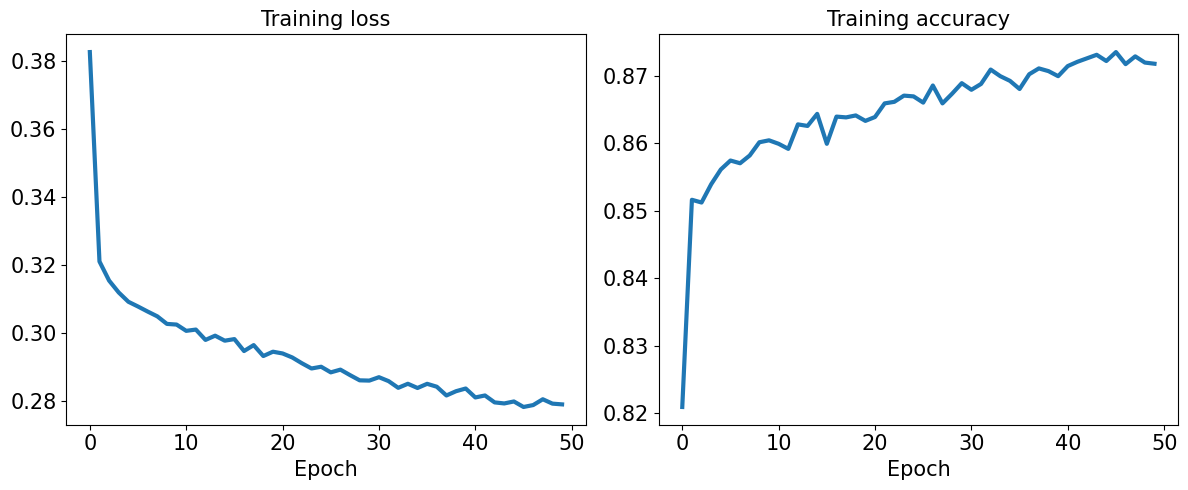

In [444]:
# plotting the loss and accuracy
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(best_loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

# second subplot
ax = fig.add_subplot(1, 2, 2)
ax.plot(best_accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()

In [ ]:
# Load the best model for further evaluation and predictions
best_model = Model_2(input_size=X_train.shape[1],
                   hidden_size=best_params['hidden_size'],
                   output_size=1, dropout_rate=0.3)

best_model.load_state_dict(torch.load("best_model.pt"))

<All keys matched successfully>

### Testing different thresholds to ensure we have the best accuracy

Best Threshold: 0.46, Accuracy: 0.8566


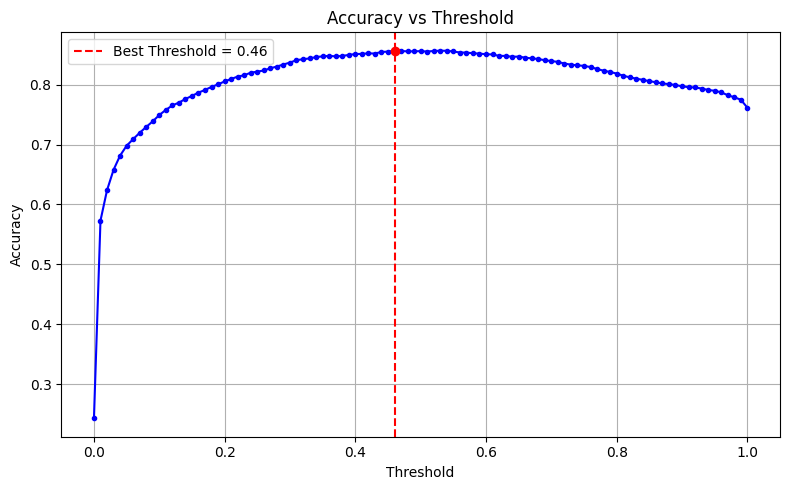

In [453]:
# evaluate best model on test set across different thresholds
best_model.eval()

# convert to probabilities
pred_probs = torch.sigmoid(best_model(X_test))

# thresholds from 0 to 1
thresholds = np.linspace(0, 1, 101)  # from 0.0 to 1.0
accuracies = []

# calculate accuracy for each threshold
for t in thresholds:
    pred_labels = (pred_probs.squeeze(1) >= t).float()
    accuracy = (pred_labels == y_test).float().mean().item()
    accuracies.append(accuracy)

# Find best threshold
best_idx = np.argmax(accuracies)
best_threshold = thresholds[best_idx]
print(f"Best Threshold: {best_threshold:.2f}, Accuracy: {accuracies[best_idx]:.4f}")

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, accuracies, marker='o', markersize=3, linestyle='-', color='blue')
plt.title('Accuracy vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.grid(True)

# Highlight the best threshold
best_accuracy = accuracies[best_idx]
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.scatter(best_threshold, best_accuracy, color='red', zorder=5)
plt.legend()

# Save the plot
plt.tight_layout()
plt.savefig('accuracy_vs_threshold.png')

In [454]:
# Calculate ROC AUC for the best model
y_true = y_test.detach().numpy()
y_scores = pred_probs.squeeze(1).detach().numpy()

# false positive rate, true positive rate, thresholds
fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

print(f"ROC AUC: {roc_auc:.4f}")

ROC AUC: 0.9097


In [455]:
# Load the best model and make final predictions on test set
best_model.eval()

pred_test = best_model(X_test)

# apply torch.sigmoid to conver outputs to probabilities
pred_probs = torch.sigmoid(pred_test)
pred_labels = (pred_probs.squeeze(1) >= 0.46).float()

# calculate accuracy
accuracy = (pred_labels == y_test).float().mean()

print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.8566


## Applying Model to Validation Dataset

In [450]:
# converting to PyTorch tensor
X_validation = torch.from_numpy(X_df_test.loc[:,feature_cols].values).float()

In [456]:
# Load the best model and make final predictions on validation set
best_model.eval()

# making predictions on the validation set using the loaded model
pred_validation = best_model(X_validation)

# apply torch.sigmoid to conver outputs to probabilities
pred_valdiation_probs = torch.sigmoid(pred_validation)

# define threshold for classification using best threshold found earlier
pred_validation_labels = (pred_valdiation_probs.squeeze(1) >= 0.46).float()

# Convert predictions to DataFrame
df = pd.DataFrame(pred_validation_labels.numpy(), 
                  columns=['Prediction'])
df.index.name = 'Index' 

# transform predictions to match submission format
pred_validation_labels_transformed = pred_validation_labels * 2 - 1  # convert 0→-1 and 1→1

# Convert predictions to DataFrame
df_transformed = pd.DataFrame(pred_validation_labels_transformed.numpy(), 
                  columns=['Prediction'])
df_transformed.index.name = 'Index' 

# Save to CSV
df_transformed.to_csv('Group_2_MLP_PredictedOutputs.csv', index=True)

In [457]:
# Double check the transformation worked as expected
display(df.head(10))
display(df_transformed.head(10))

,Prediction
Index,
0,0.0
1,1.0
2,1.0
3,0.0
4,0.0
5,1.0
6,1.0
7,0.0
8,0.0


,Prediction
Index,
0,-1.0
1,1.0
2,1.0
3,-1.0
4,-1.0
5,1.0
6,1.0
7,-1.0
8,-1.0
